In [1]:
from collections import defaultdict
import csv
from itertools import islice
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import scipy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [2]:
progan_filenames = torch.load('progan_filenames.pt', map_location=torch.device('cpu'))
progan_distance_features = torch.load('small_progan_distance_features.pt', map_location=torch.device('cpu'))

In [3]:
stylegan_filenames = torch.load('stylegan_filenames.pt', map_location=torch.device('cpu'))
stylegan_distance_features = torch.load('stylegan_distance_features.pt', map_location=torch.device('cpu'))

In [4]:
began_filenames = torch.load('began_filenames.pt', map_location=torch.device('cpu'))
began_distance_features = torch.load('began_distance_features.pt', map_location=torch.device('cpu'))

In [5]:
dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        if dataset_name == 'began5000' and row['realness'] == 'True': print(row)

        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [6]:
progan_votes = img_votes['progan5000']
began_votes = img_votes['began5000']
stylegan_votes = img_votes['styleganceleba5000']
len(progan_votes), len(began_votes), len(stylegan_votes)

(2233, 2397, 3103)

In [7]:
began_votes_filtered = {k:v for k,v in began_votes.items() if k in [os.path.split(x)[-1] for x in began_filenames]}

len(began_votes_filtered)

1966

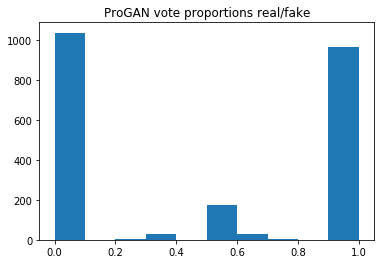

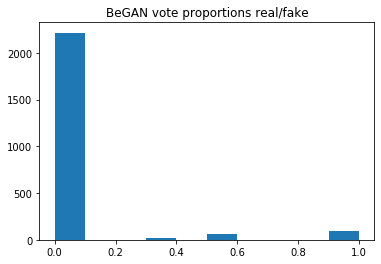

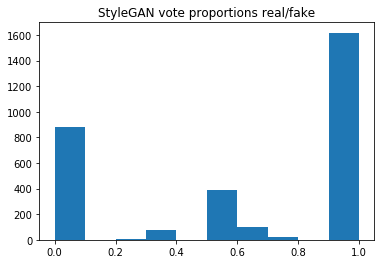

In [8]:
for gan, votes in [('ProGAN', progan_votes), ('BeGAN', began_votes), ('StyleGAN', stylegan_votes)]:
    vote_pct_correct = [y/(x+y) for x,y in votes.values()]
    plt.title(gan + ' vote proportions real/fake')
    plt.hist(vote_pct_correct)
    plt.show()

In [9]:
print(sum([x[0] for x in progan_votes.values()]), sum([x[1] for x in progan_votes.values()]))

print(sum([x[0] for x in stylegan_votes.values()]), sum([x[1] for x in stylegan_votes.values()]))

1530 1456
1814 2983


In [10]:
with open('train_set.txt') as f:
    progan_train_files = [x.strip() for x in f.readlines()]
#print(progan_train_files[:5])

with open('val_set.txt') as f:
    progan_val_files = [x.strip() for x in f.readlines()]
#print(progan_val_files[:5])

with open('stylegan_train_set.txt') as f:
    stylegan_train_files = [x.strip() for x in f.readlines()]
#print(stylegan_train_files[:5])

with open('stylegan_val_set.txt') as f:
    stylegan_val_files = [x.strip() for x in f.readlines()]
#print(stylegan_val_files[:5])

with open('began_train_set.txt') as f:
    began_train_files = [x.strip() for x in f.readlines()]
#print(began_train_files[:5])

with open('began_val_set.txt') as f:
    began_val_files = [x.strip() for x in f.readlines()]
#print(began_val_files[:5])

In [11]:
progan_features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
print(len(progan_features_by_file))

stylegan_features_by_file = {stylegan_filenames[i] : stylegan_distance_features[i] for i in range(len(stylegan_filenames))}
print(len(stylegan_features_by_file))

began_features_by_file = {began_filenames[i] : began_distance_features[i] for i in range(len(began_filenames))}
print(len(began_features_by_file))

2233
3103
1966


In [12]:
progan_votes_by_file = {'imgs_by_label/progan_labeled/progan_labeled_imgs/' + k : v for k,v in progan_votes.items()}
print(len(progan_votes_by_file))

stylegan_votes_by_file = {'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/' + k : v for k,v in stylegan_votes.items()}
print(len(stylegan_votes_by_file))

began_votes_by_file = {'imgs_by_label/began_labeled/began_labeled_imgs/' + k : v for k,v in began_votes_filtered.items()}
print(len(began_votes_by_file))

2233
3103
1966


In [13]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_progan_train = []
Y_progan_train = []
for f in tqdm_notebook(progan_train_files):
    cur_feats = progan_features_by_file[f]
    cur_votes = progan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    #print(false_votes + true_votes)
    #print(f, cur_feats, cur_votes, '\n')
    
    for i in range(false_votes):
        X_progan_train.append(cur_feats)
        Y_progan_train.append(0)
        
    for i in range(true_votes):
        X_progan_train.append(cur_feats)
        Y_progan_train.append(1)

len(X_progan_train), len(Y_progan_train)

(2369, 2369)

In [14]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_progan_val = []
Y_progan_val = []
for f in tqdm_notebook(progan_val_files):
    cur_feats = progan_features_by_file[f]
    cur_votes = progan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_progan_val.append(cur_feats)
        Y_progan_val.append(0)
        
    for i in range(true_votes):
        X_progan_val.append(cur_feats)
        Y_progan_val.append(1)
len(X_progan_val), len(Y_progan_val)

(306, 306)

In [15]:
lr_progan = LogisticRegression().fit(X_progan_train, Y_progan_train)
lr_progan.score(X_progan_train, Y_progan_train), lr_progan.score(X_progan_val, Y_progan_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.6361333896158716, 0.6503267973856209)

In [16]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_stylegan_train = []
Y_stylegan_train = []
for f in tqdm_notebook(stylegan_train_files):
    cur_feats = stylegan_features_by_file[f]
    cur_votes = stylegan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_stylegan_train.append(cur_feats)
        Y_stylegan_train.append(0)
        
    for i in range(true_votes):
        X_stylegan_train.append(cur_feats)
        Y_stylegan_train.append(1)

len(X_stylegan_train), len(Y_stylegan_train)

(3849, 3849)

In [17]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_stylegan_val = []
Y_stylegan_val = []
for f in tqdm_notebook(stylegan_val_files):
    cur_feats = stylegan_features_by_file[f]
    cur_votes = stylegan_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_stylegan_val.append(cur_feats)
        Y_stylegan_val.append(0)
        
    for i in range(true_votes):
        X_stylegan_val.append(cur_feats)
        Y_stylegan_val.append(1)
len(X_stylegan_val), len(Y_stylegan_val)

(485, 485)

In [18]:
lr_stylegan = LogisticRegression().fit(X_stylegan_train, Y_stylegan_train)
lr_stylegan.score(X_stylegan_train, Y_stylegan_train), lr_stylegan.score(X_stylegan_val, Y_stylegan_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.6282151208106002, 0.6639175257731958)

In [19]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_began_train = []
Y_began_train = []
for f in tqdm_notebook(began_train_files):
    cur_feats = began_features_by_file[f]
    cur_votes = began_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_began_train.append(cur_feats)
        Y_began_train.append(0)
        
    for i in range(true_votes):
        X_began_train.append(cur_feats)
        Y_began_train.append(1)

len(X_began_train), len(Y_began_train)

(2140, 2140)

In [20]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_began_val = []
Y_began_val = []
for f in tqdm_notebook(began_val_files):
    cur_feats = began_features_by_file[f]
    cur_votes = began_votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_began_val.append(cur_feats)
        Y_began_val.append(0)
        
    for i in range(true_votes):
        X_began_val.append(cur_feats)
        Y_began_val.append(1)
len(X_began_val), len(Y_began_val)

(248, 248)

In [21]:
lr_began = LogisticRegression().fit(X_began_train, Y_began_train)
lr_began.score(X_began_train, Y_began_train), lr_began.score(X_began_val, Y_began_val)

/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9457943925233645, 0.9556451612903226)

P-correct for each example
0.5509021380125019 0.14111175386278635


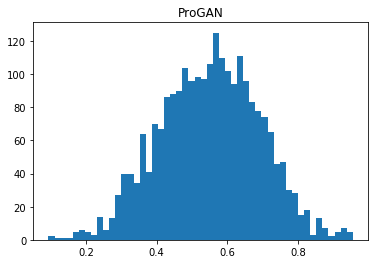

0.5404354440023837 0.13265175526874465


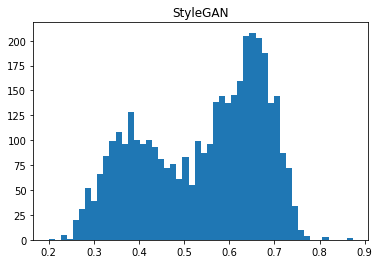

0.8975330884284839 0.20172465325344524


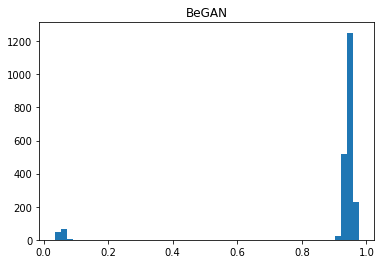

In [22]:
print('P-correct for each example')

probs = lr_progan.predict_proba(X_progan_train)
true_probs = np.array([probs[i][Y_progan_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('ProGAN')
plt.show()


probs = lr_stylegan.predict_proba(X_stylegan_train)
true_probs = np.array([probs[i][Y_stylegan_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('StyleGAN')
plt.show()

probs = lr_began.predict_proba(X_began_train)
true_probs = np.array([probs[i][Y_began_train[i]] for i in range(len(probs))])

plt.hist(true_probs, bins=50)
print(np.mean(true_probs), np.std(true_probs))
plt.title('BeGAN')
plt.show()

Now, for the inter-GAN comparisons:

In [23]:
lr_progan.score(X_stylegan_train, Y_stylegan_train), lr_progan.score(X_stylegan_val, Y_stylegan_val) 

(0.614445310470252, 0.6474226804123712)

In [24]:
print(
    np.mean([guess for guess, true in zip(lr_progan.predict(X_stylegan_train), Y_stylegan_train) if true == 1]),
    np.mean([1. - guess for guess, true in zip(lr_progan.predict(X_stylegan_train), Y_stylegan_train) if true == 0])
)
print('ProGAN is overconfident on StyleGAN quality')

0.8019549511262218 0.3195187165775401
ProGAN is overconfident on StyleGAN quality


In [25]:
lr_progan.score(X_began_train, Y_began_train), lr_progan.score(X_began_val, Y_began_val) 

(0.6224299065420561, 0.6451612903225806)

In [26]:
lr_stylegan.score(X_progan_train, Y_progan_train), lr_stylegan.score(X_progan_val, Y_progan_val) 

(0.6103841283241874, 0.5882352941176471)

In [27]:
print(
    np.mean([guess for guess, true in zip(lr_stylegan.predict(X_progan_train), Y_progan_train) if true == 1]),
    np.mean([1. - guess for guess, true in zip(lr_stylegan.predict(X_progan_train), Y_progan_train) if true == 0])
)
print('StyleGAN is overconfident on ProGAN quality')

0.8676345004269855 0.3589315525876461
StyleGAN is overconfident on ProGAN quality


In [28]:
lr_stylegan.score(X_began_train, Y_began_train), lr_stylegan.score(X_began_val, Y_began_val) 

(0.3644859813084112, 0.3951612903225806)

In [29]:
lr_began.score(X_progan_train, Y_progan_train), lr_began.score(X_progan_val, Y_progan_val) 

(0.5056986070071761, 0.5294117647058824)

In [30]:
lr_began.score(X_stylegan_train, Y_stylegan_train), lr_began.score(X_stylegan_val, Y_stylegan_val) 

(0.38867238243699664, 0.3422680412371134)

And now to train on 2 datasets at a time

In [31]:
lr_progan_stylegan = LogisticRegression().fit(X_progan_train + X_stylegan_train, Y_progan_train + Y_stylegan_train)
print(lr_progan_stylegan.score(X_progan_train + X_stylegan_train, Y_progan_train + Y_stylegan_train))
print(lr_progan_stylegan.score(X_progan_val + X_stylegan_val, Y_progan_val + Y_stylegan_val))

print('\nAnd now on BeGAN')
print(lr_progan_stylegan.score(X_began_train, Y_began_train))
print(lr_progan_stylegan.score(X_began_val, Y_began_val))


0.6276937922161466
0.6485461441213654

And now on BeGAN
0.49439252336448597
0.5161290322580645


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
lr_progan_began = LogisticRegression().fit(X_progan_train + X_began_train, Y_progan_train + Y_began_train)
print(lr_progan_began.score(X_progan_train + X_began_train, Y_progan_train + Y_began_train))
print(lr_progan_began.score(X_progan_val + X_began_val, Y_progan_val + Y_began_val))

print('\nAnd now on stylegan')
print(lr_progan_began.score(X_stylegan_train, Y_stylegan_train))
print(lr_progan_began.score(X_stylegan_val, Y_stylegan_val))


0.759591927256598
0.779783393501805

And now on stylegan
0.5401402961808262
0.511340206185567


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
lr_stylegan_began = LogisticRegression().fit(X_stylegan_train + X_began_train, Y_stylegan_train + Y_began_train)
print(lr_stylegan_began.score(X_stylegan_train + X_began_train, Y_stylegan_train + Y_began_train))
print(lr_stylegan_began.score(X_stylegan_val + X_began_val, Y_stylegan_val + Y_began_val))

print('\nAnd now on progan')
print(lr_stylegan_began.score(X_progan_train, Y_progan_train))
print(lr_stylegan_began.score(X_progan_val, Y_progan_val))


0.7064618467189848
0.6766712141882674

And now on progan
0.5892781764457578
0.6274509803921569


/home/alexkolchinski/.conda/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
with open('expanded_progan_val_set.csv') as f:
    human_scores = {l.strip().split(',')[0][5:] : float(l.strip().split(',')[1]) for l in f.readlines()[1:] if 'fake' in l}

print(len(human_scores))
extended_progan_val_files = set(human_scores.keys())


progan_val_files_short = set([os.path.split(x)[-1] for x in progan_val_files])
print(len(extended_progan_val_files.intersection(progan_val_files_short)))
print(len(progan_val_files_short))
# for k,v in human_scores.items():
#     print(k,v)

250
200
223


In [35]:
expanded_progan_val_files_filtered = extended_progan_val_files.intersection(progan_val_files_short)
len(expanded_progan_val_files_filtered)

200

In [36]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_progan_val_extended = []
Y_progan_val_extended = []
for f in tqdm_notebook(expanded_progan_val_files_filtered):
    cur_feats = progan_features_by_file['imgs_by_label/progan_labeled/progan_labeled_imgs/' + f]
    
    human_score = human_scores[f]
    print(cur_feats, human_score)
    
    X_progan_val_extended.append(cur_feats)
    Y_progan_val_extended.append(human_score)
    

len(X_progan_val_extended), len(Y_progan_val_extended)

[ 0.03839695  0.21412626  0.29571125  4.6280212   3.5433905  22.610014
 22.376955  ] 0.8
[ 0.02747115  0.18490836  0.25482038  4.115768    3.172318   17.28219
 13.029121  ] 0.2
[ 0.03622212  0.196615    0.27684963  4.3583207   3.539715   22.668312
 18.33124   ] 0.4
[ 0.02137414  0.13128965  0.18796144  3.949545    3.4287825  20.229092
 20.256943  ] 0.2
[ 0.03561979  0.2021311   0.28175855  4.311711    3.199368   17.80849
 15.703584  ] 0.4
[ 0.02637715  0.16629015  0.23834303  4.0080357   2.667103   12.40134
 10.433835  ] 0.0
[ 0.02730314  0.15542723  0.22123484  3.9580996   2.9364753  16.898272
 15.060287  ] 0.4
[ 0.0249817   0.1327697   0.18523675  3.791088    3.430824   17.271347
 15.080267  ] 0.2
[ 0.03500325  0.21154685  0.29398265  4.3979745   3.0346122  15.400112
 13.336246  ] 0.0
[ 0.02523996  0.1638503   0.23293838  4.113064    2.7387981  14.857898
 12.202662  ] 0.4
[ 0.02800401  0.17807387  0.25857058  4.223801    3.1949403  16.527824
 14.120131  ] 0.6
[ 0.03058864  0.18544763

[ 0.0338425   0.19648522  0.27877867  4.3975344   3.184761   18.566788
 16.590488  ] 0.6
[ 0.02983325  0.20775759  0.3108127   4.7475805   3.1660755  18.413755
 12.672115  ] 0.6
[ 0.04777538  0.27606946  0.3916721   4.7757244   3.8400066  19.492397
 16.24875   ] 0.6
[ 0.03874654  0.17652471  0.24200794  4.182493    3.2571268  21.421417
 18.145132  ] 0.2
[ 0.03940187  0.16535136  0.22105886  4.1778135   3.336459   16.10353
 15.515136  ] 0.6
[ 0.02330642  0.15353732  0.21971546  3.9604888   3.0756533  17.56595
 13.3111725 ] 0.6
[ 0.02392511  0.14735411  0.21298079  4.071719    3.3303072  15.47029
 14.659341  ] 0.6
[ 0.0316699   0.14534384  0.1951339   3.4902823   3.4680004  17.550964
 16.008657  ] 1.0
[ 0.07326904  0.24208562  0.33670667  4.493261    3.640022   20.51228
 18.5252    ] 1.0
[ 0.02891503  0.1672123   0.23537795  4.4216805   3.512694   18.085484
 14.192013  ] 0.2
[ 0.02608255  0.15435156  0.21713296  3.934737    3.0847964  16.484997
 13.148505  ] 0.2
[ 0.02322802  0.15898326 

(200, 200)

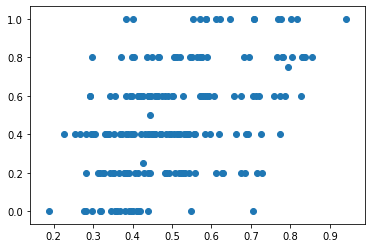

array([[1.        , 0.47305105],
       [0.47305105, 1.        ]])

In [41]:
progan_prob_real = [x[0] for x in lr_progan.predict_proba(X_progan_val_extended)]
plt.scatter(progan_prob_real, Y_progan_val_extended)
plt.show()

np.corrcoef(progan_prob_real, Y_progan_val_extended)

In [42]:
scipy.stats.spearmanr(progan_prob_real, Y_progan_val_extended)

SpearmanrResult(correlation=0.4566808902206836, pvalue=1.0692559646829754e-11)

In [40]:
1. - lr_progan.score(X_progan_val_extended, (np.array(Y_progan_val_extended) > .5)*1)

0.6599999999999999

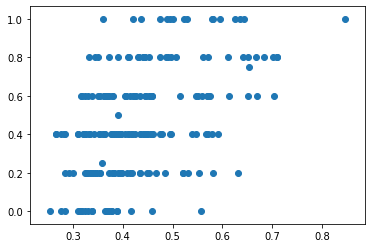

array([[1.        , 0.47983502],
       [0.47983502, 1.        ]])

In [44]:
stylegan_prob_real = [x[0] for x in lr_stylegan.predict_proba(X_progan_val_extended)]
plt.scatter(stylegan_prob_real, Y_progan_val_extended)
plt.show()

np.corrcoef(stylegan_prob_real, Y_progan_val_extended)

In [45]:
scipy.stats.spearmanr(stylegan_prob_real, Y_progan_val_extended)

SpearmanrResult(correlation=0.46227436801747096, pvalue=5.544658152798465e-12)

In [64]:
img_yes_votes = defaultdict(int)
img_all_votes = defaultdict(int)

with open('stylegan_human_scores_cleaned.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in islice(spamreader,1,None):
        filename = row[0]
        if 'styleGAN' not in filename: continue
            
        is_correct = row[2]
        
        img_all_votes[filename] += 1
        if is_correct == 'True':
            img_yes_votes[filename] += 1

In [68]:
len(img_yes_votes.keys()), len(img_all_votes.keys())

(231, 249)

In [72]:
stylegan_val_files

['imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1006.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1025.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1043.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1059.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1070.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1083.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_11.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_111.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1128.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1141.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1154.png',
 'imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/celeba_styleGAN_1165.png',
 'imgs_by_label/sty

In [81]:
extended_stylegan_val_files = ['imgs_by_label/stylegan_labeled/stylegan_labeled_imgs/' + x[5:] for x in img_all_votes.keys()]
extended_stylegan_val_files = set(extended_stylegan_val_files).intersection(stylegan_val_files)
len(extended_stylegan_val_files)

200

In [89]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_stylegan_val_extended = []
Y_stylegan_val_extended = []
for f in tqdm_notebook(extended_stylegan_val_files):
    cur_feats = stylegan_features_by_file[f]
    
    short_f = 'fake_' + os.path.split(f)[-1]
    
    yes_votes = img_yes_votes[short_f] if short_f in img_yes_votes else 0
    all_votes = img_all_votes[short_f]
    #print(short_f)
    frac = yes_votes / all_votes
    
    #human_score = human_scores[f]
    print(cur_feats, frac)
    
    X_stylegan_val_extended.append(cur_feats)
    Y_stylegan_val_extended.append(frac)
    

len(X_stylegan_val_extended), len(Y_stylegan_val_extended)

[ 0.02455453  0.1628937   0.2335049   4.0549293   2.9261105  15.248383
 13.834675  ] 0.2
[ 0.02274663  0.1305209   0.18712787  3.75182     2.9040768  17.374565
 13.283935  ] 0.6
[ 0.03048408  0.16460763  0.23471862  4.177192    2.8745518  15.085127
 12.980474  ] 0.6
[ 0.02766354  0.15834095  0.22889996  4.172201    3.0653448  15.906843
 14.962028  ] 0.2
[ 0.02581247  0.18303825  0.2683467   4.2586102   3.1242247  15.589457
 14.444795  ] 0.2
[ 0.03272982  0.19785953  0.28137732  4.310068    2.98724    15.768664
 12.084391  ] 0.6
[ 0.02623962  0.16824515  0.2426642   4.160694    2.9299629  15.986147
 14.723061  ] 0.2
[ 0.02439146  0.1429479   0.2007576   3.8796656   3.001131   17.102049
 17.773626  ] 0.8
[ 0.02974452  0.17155361  0.24772477  4.4453354   3.178909   16.7106
 13.913779  ] 0.8
[ 0.02764879  0.19138731  0.27895078  4.3990097   3.0560741  17.036121
 14.350538  ] 0.2
[ 0.02604506  0.15938738  0.23065795  4.3324575   2.9320405  14.870051
 13.177397  ] 0.6
[ 0.0268682   0.1860547

(200, 200)

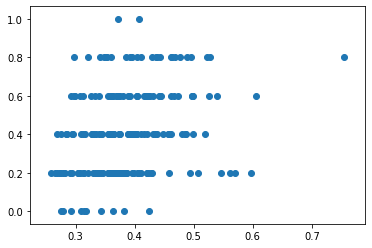

array([[1.      , 0.303484],
       [0.303484, 1.      ]])

In [90]:
stylegan_prob_real_2 = [x[0] for x in lr_stylegan.predict_proba(X_stylegan_val_extended)]
plt.scatter(stylegan_prob_real_2, Y_stylegan_val_extended)
plt.show()

np.corrcoef(stylegan_prob_real_2, Y_stylegan_val_extended)

In [91]:
scipy.stats.spearmanr(stylegan_prob_real_2, Y_stylegan_val_extended)

SpearmanrResult(correlation=0.3139866010254341, pvalue=5.964643132922672e-06)

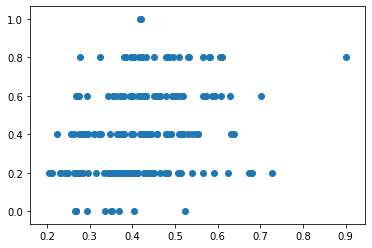

array([[1.        , 0.29811497],
       [0.29811497, 1.        ]])

In [92]:
progan_prob_real_2 = [x[0] for x in lr_progan.predict_proba(X_stylegan_val_extended)]
plt.scatter(progan_prob_real_2, Y_stylegan_val_extended)
plt.show()

np.corrcoef(progan_prob_real_2, Y_stylegan_val_extended)